In [1]:
import numpy as np
from util.guided_ot import *
from util.pqdict import pqdict
from util.simplicial_paths import *
from util.alg_perf import dijkstra_tree, plot_proj_diffs

In [2]:
def augmented_dijkstra_v3(SC, start, end, ref_path, alpha,  num_extra=0, other=False):
    def backtrace(prev, start, end):
        path, node = [], end
        while node != start:
            path.append(node)
            node = prev[node]
        path.append(node) 
        path.reverse()
        return path
    
    def get_next_proj(u, v, curr_proj):
        edge = Trajectory(SC, [u,v], num_extra)
        proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
        next_proj = curr_proj + proj
        return next_proj

    def proj_cost(proj, ref_proj):
        proj_diff = np.linalg.norm(proj - ref_proj, 1)
        return np.round(proj_diff, 16)

    def cost(u, v, proj, edge_weight, ref_proj):
        edge_cost = SC.graph[u][v]['weight']
        next_edge_weight = edge_weight + edge_cost
        next_proj = get_next_proj(u, v, proj)
        next_proj_diff = proj_cost(next_proj, ref_proj)
        potential_cost = next_edge_weight + alpha * next_proj_diff
        return potential_cost, next_proj, next_edge_weight
    
    def get_ref_proj(idx):
        if 0 <= idx < len(ref_path.path_edges):
            proj = ref_path.edge_projections[idx]
        elif idx < 0:
            proj = np.inf * np.ones(dim_proj)
        else:
            proj = ref_path.edge_projections[-1]
        return proj

    def init():
        prev = {}
        edge_sum = {v:np.inf for v in range(SC.node_vec.shape[0])}
        dist2src = {v:-1 for v in range(SC.node_vec.shape[0])}
        cost_dict = {v:np.inf for v in range(SC.node_vec.shape[0])}
        node_proj = {v:np.inf * np.ones(dim_proj) for v in range(SC.node_vec.shape[0])}

        visited = set()
        pq = pqdict()

        for i  in np.where(SC.node_vec == 1)[0]:
            pq[i] = float("inf") if (i != start) else 0

        dist2src[start], edge_sum[start] = 0, 0, 
        node_proj[start], cost_dict[start] = np.zeros(dim_proj), 0    

        return prev, edge_sum, dist2src, cost_dict, node_proj, visited, pq

    dim_proj = (SC.H.shape[0] + num_extra) if (num_extra > 0) else SC.H.shape[0]
    prev, edge_sum, dist2src, cost_dict, node_proj, visited, pq = init()

    node_children = {node:0 for node in np.where(SC.node_vec == 1)[0]}


    while len(pq) > 0:
        u = pq.pop()
        proj_u = node_proj[u]
        weight_u = edge_sum[u]
        n_edges_u = dist2src[u]
        visited.add(u)
        n_edges_v = n_edges_u + 1        

        num_children = 0

        for v in SC.graph.neighbors(u): # v = neighbor of lowest cost node u
            if v in visited: # node must not have already been visited
                continue

            ref_proj = get_ref_proj(n_edges_v)
            new_cost, new_proj_v, new_edge_sum_v = cost(u, v, proj_u, weight_u, ref_proj)
            old_cost = cost_dict[v]

            if new_cost < old_cost:
                if v in prev:
                    node_children[prev[v]] -= 1
                num_children += 1
                
                proj_diff = np.linalg.norm(new_proj_v - ref_proj, 1)
                edge_weight = new_edge_sum_v - edge_sum[u]
                cost_dict[v] = new_cost
                prev[v] = u
                edge_sum[v] = new_edge_sum_v
                node_proj[v] = new_proj_v
                dist2src[v] = n_edges_v
                pq[v] = new_cost
            
        node_children[u] = num_children

    path = Trajectory(SC, backtrace(prev, start, end), num_extra)

    heads = [node for node in node_children if not node_children[node]]

    other_paths = [Trajectory(SC, backtrace(prev, start, head), num_extra) for head in heads if head != end]

    if not other:
        return path
    else:
        return path, other_paths

In [3]:
def augmented_dijkstra_v4(SC, start, end, ref_path, alpha,  num_extra=0, other=False):
    def backtrace(prev, start, end):
        path, node = [], end
        while node != start:
            path.append(node)
            node = prev[node]
        path.append(node) 
        path.reverse()
        return path
    
    def get_next_proj(u, v, curr_proj):
        edge = Trajectory(SC, [u,v], num_extra)
        proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
        next_proj = curr_proj + proj
        return next_proj

    def proj_cost(proj, ref_proj):
        proj_diff = np.linalg.norm(proj - ref_proj, np.inf)
        return np.round(proj_diff, 16)

    def cost(u, v, proj, edge_weight, ref_proj):
        edge_cost = SC.graph[u][v]['weight']
        next_edge_weight = edge_weight + edge_cost
        next_proj = get_next_proj(u, v, proj)
        next_proj_diff = proj_cost(next_proj, ref_proj)
        potential_cost = next_edge_weight + alpha * next_proj_diff
        return potential_cost, next_proj, next_edge_weight
    
    def get_ref_proj(idx):
        if 0 <= idx < len(ref_path.path_edges):
            proj = ref_path.edge_projections[idx]
        elif idx < 0:
            proj = np.inf * np.ones(dim_proj)
        else:
            proj = ref_path.edge_projections[-1]
        return proj

    def init():
        prev = {}
        edge_sum = {v:np.inf for v in range(SC.node_vec.shape[0])}
        dist2src = {v:-1 for v in range(SC.node_vec.shape[0])}
        cost_dict = {v:np.inf for v in range(SC.node_vec.shape[0])}
        node_proj = {v:np.inf * np.ones(dim_proj) for v in range(SC.node_vec.shape[0])}

        visited = set()
        pq = pqdict()

        for i  in np.where(SC.node_vec == 1)[0]:
            pq[i] = float("inf") if (i != start) else 0

        dist2src[start], edge_sum[start] = 0, 0, 
        node_proj[start], cost_dict[start] = np.zeros(dim_proj), 0    


        return prev, edge_sum, dist2src, cost_dict, node_proj, visited, pq

    dim_proj = (SC.H.shape[0] + num_extra) if (num_extra > 0) else SC.H.shape[0]
    prev, edge_sum, dist2src, cost_dict, node_proj, visited, pq = init()

    node_children = {node:0 for node in np.where(SC.node_vec == 1)[0]}


    while len(pq) > 0:
        u = pq.pop()
        proj_u = node_proj[u]
        weight_u = edge_sum[u]
        n_edges_u = dist2src[u]
        visited.add(u)
        n_edges_v = n_edges_u + 1        

        num_children = 0

        for v in SC.graph.neighbors(u): # v = neighbor of lowest cost node u
            if v in visited: # node must not have already been visited
                continue

            ref_proj = get_ref_proj(n_edges_v)
            new_cost, new_proj_v, new_edge_sum_v = cost(u, v, proj_u, weight_u, ref_proj)
            old_cost = cost_dict[v]

            if new_cost < old_cost:
                if v in prev:
                    node_children[prev[v]] -= 1
                num_children += 1
                
                proj_diff = np.linalg.norm(new_proj_v - ref_proj, 1)
                edge_weight = new_edge_sum_v - edge_sum[u]
                cost_dict[v] = new_cost
                prev[v] = u
                edge_sum[v] = new_edge_sum_v
                node_proj[v] = new_proj_v
                dist2src[v] = n_edges_v
                pq[v] = new_cost
            
        node_children[u] = num_children

    path = Trajectory(SC, backtrace(prev, start, end), num_extra)

    heads = [node for node in node_children if not node_children[node]]

    other_paths = [Trajectory(SC, backtrace(prev, start, head), num_extra) for head in heads if head != end]

    if not other:
        return path
    else:
        return path, other_paths

# Setup Domain

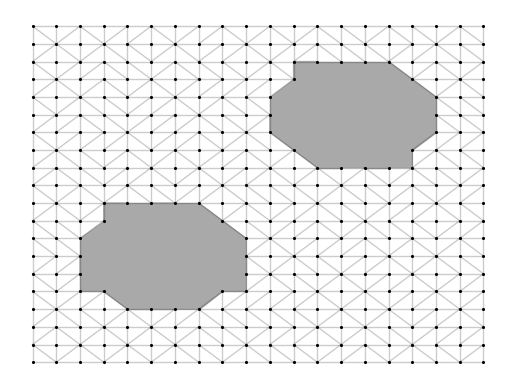

In [13]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

# Setup reference path

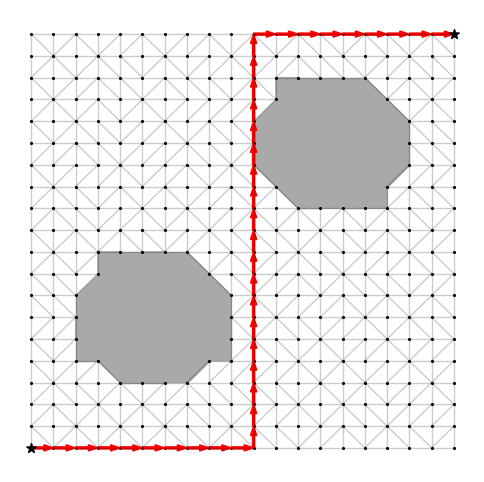

In [14]:
ref_path_coords = [(-1,-1), (0,-1), (0,1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')

# Setup shortest path

In [1]:
shortest_path_coords = [(-1,-1), (1,1)]
num_paths, num_nodes = 1, 1

shortest_path_class = Trajectory_Class(SC)
shortest_path_class.generate_paths(shortest_path_coords, num_paths, num_nodes, 1e-1)
shortest_path = shortest_path_class.paths[0]

NameError: name 'Trajectory_Class' is not defined

In [10]:
shortest_path_weight = shortest_path.path_length[-1]
shortest_path_proj_cumulative_diff = np.sum(np.linalg.norm(shortest_path.edge_projections - ref_path.edge_projections[-1], ord=1, axis=1))
len_path = len(shortest_path.nodes)
shortest_path_proj_diff = np.linalg.norm(shortest_path.edge_projections - ref_path.edge_projections[0,:len_path], ord=1)

In [14]:
np.linalg.norm(shortest_path.edge_projections - ref_path.edge_projections[:len_path], ord=1, axis=1)

array([0.        , 0.        , 0.        , 0.        , 0.00565815,
       0.00680187, 0.02808779, 0.06080897, 0.07914342, 0.11458362,
       0.16508865, 0.19147837, 0.17355592, 0.15804379, 0.1981116 ,
       0.20807221, 0.21041189, 0.27515071, 0.40181257, 0.52798897,
       0.63652929, 0.8323179 , 0.96893051, 1.0539976 , 1.20097277,
       1.30199188])

In [11]:
alpha_crit_v4 = shortest_path_weight / shortest_path_proj_cumulative_diff
alpha_crit_v3 = shortest_path_weight / shortest_path_proj_diff

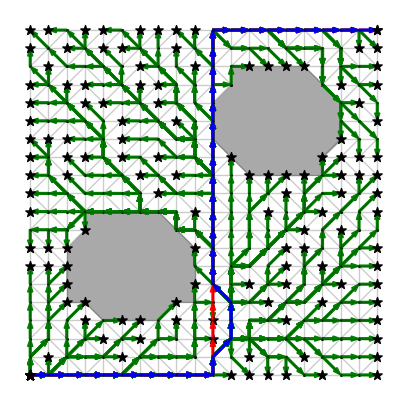

0-1-2-3-4-5-6-7-8-9-10-11
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8.30180939e-04  3.20859660e-01]
 [-1.87097569e-03  3.95654095e-01]
 [-3.68503954e-03  4.51274314e-01]
 [-6.27965196e-03  4.96249736e-01]
 [-1.11467078e-02  5.44977703e-01]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8.30180939e-04  3.20859660e-01]
 [-1.87097569e-03  3.95654095e-01]
 [-3.68503954e-03  4.51274314e-01]
 [-6.27965196e-03  4.96249736e-01]
 [-1.11467078e-02  5.44977703e-01]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.728931

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


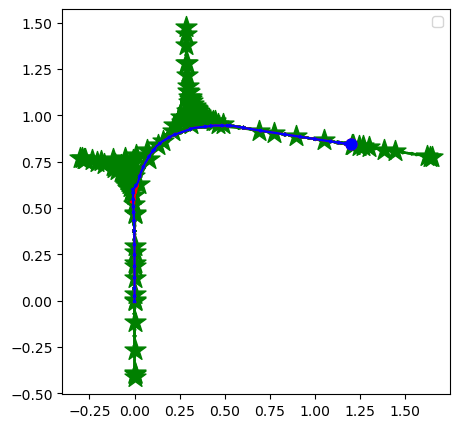

In [15]:
alpha_crit_v4 = 10
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha_crit_v4, 0,  True)
dijkstra_tree(SC, path, opther_paths, ref_path_class, plot_others=True)

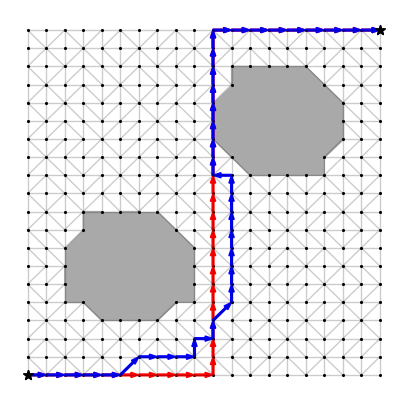

0-1-2-3-4-5-6-7-8-9-10-30-50-70-90-110-130-150-170-190-210-230-250-270-290-310-330-350-370-390-391-392-393-394-395-396-397-398-399
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8.30180939e-04  3.20859660e-01]
 [-1.87097569e-03  3.95654095e-01]
 [-3.68503954e-03  4.51274314e-01]
 [-6.27965196e-03  4.96249736e-01]
 [-7.38236953e-03  5.26827813e-01]
 [-2.90061912e-03  5.22491934e-01]
 [-1.39321054e-03  5.68759934e-01]
 [ 6.12253307e-03  5.80219792e-01]
 [ 1.80518012e-02  6.37006928e-01]
 [ 3.44443839e-02  6.89974346e-01]
 [ 5.68751322e-02  7.39932177e-01]
 [ 8.99768543e-02  7.93332383e-01]
 [ 1.14531597e-01  8.23863924e-01]
 [ 1.18588108e-01  8.31248723e-01]
 [ 1.55329619e-01  8.60266753e-01]
 [ 2.08809334e-01  8.90987442e-01]
 [ 2.42191867e-01  9.02795300e-01]
 [ 3.27963662e-01  9.32188340

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-2.27570614e-04  2.73543231e-01]
 [-8.18617539e-04  3.47798821e-01]
 [-1.11654948e-03  3.96418567e-01]
 [-2.90449096e-03  4.61919112e-01]
 [-5.98701461e-05  4.82234185e-01]
 [-2.90061912e-03  5.22491934e-01]
 [-1.39321054e-03  5.68759934e-01]
 [ 1.89131089e-03  6.12985990e-01]
 [ 5.86780988e-03  6.50276319e-01]
 [ 1.98010454e-02  6.91122768e-01]
 [ 3.31269091e-02  7.30422747e-01]
 [ 5.39254825e-02  7.63382092e-01]
 [ 8.42186525e-02  8.00319897e-01]
 [ 9.09114211e-02  8.15626388e-01]
 [ 1.19226223e-01  8.37003460e-01]
 [ 1.55329619e-01  8.60266753e-01]
 [ 2.08809334e-01  8.90987442e-01]
 [ 2.42191867e-01  9.02795300e-01]
 [ 3.27963662e-01  9.32188340e-01]
 [ 4.10370804e-01  9.40954998e-01]
 [ 4.42163954e-01  9.45315648e-01]
 [ 5.04109993e-01  9.44407166e-01]
 [ 5.34038992e-01  9

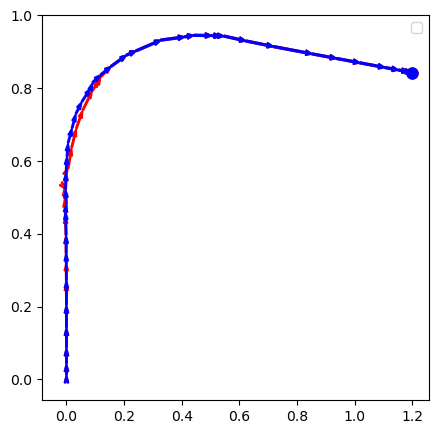

In [16]:
alpha_crit_v4 = 5
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha_crit_v4, 0,  True)
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=False)

10


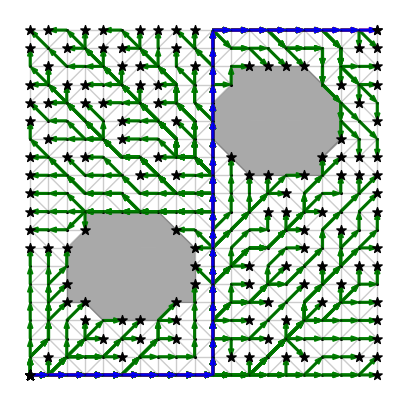

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8.30180939e-04  3.20859660e-01]
 [-1.87097569e-03  3.95654095e-01]
 [-3.68503954e-03  4.51274314e-01]
 [-6.27965196e-03  4.96249736e-01]
 [-1.11467078e-02  5.44977703e-01]
 [-1.79356120e-02  5.86889235e-01]
 [-2.52853440e-02  6.14219319e-01]
 [-3.03669912e-02  6.28214801e-01]
 [-3.58039062e-02  6.41003064e-01]
 [-4.09827190e-02  6.50746622e-01]
 [-4.49044624e-02  6.57329874e-01]
 [-4.86087356e-02  6.62801583e-01]
 [-4.95396324e-02  6.64101867e-01]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8.30180939e-04  3.20859660e-01]
 [-1.87097569e-03  3.95654095e-01]
 [-3.68503954e-03  4.51274314e-01]
 [-6.27965196e-03  4.96249736e-01]
 [-7.38236953e-03  5.26827813e-01]
 [-2.90061912e-03  5.22491934e-01]
 [-1.39321054e-03  5.68759934e-01]
 [ 6.12253307e-03  5.80219792e-01]
 [ 1.80518012e-02  6.37006928e-01]
 [ 3.44443839e-02  6.89974346e-01]
 [ 5.68751322e-02  7.39932177e-01]
 [ 8.99768543e-02  7.93332383e-01]
 [ 1.14531597e-01  8.23863924e-01]
 [ 1.18588108e-01  8.31248723e-01]
 [ 1.55329619e-01  8.60266753e-01]
 [ 2.08809334e-01  8.90987442e-01]
 [ 2.42191867e-01  9.02795300e-01]
 [ 3.27963662e-01  9.32188340e-01]
 [ 4.10370804e-01  9.40954998e-01]
 [ 4.42163954e-01  9.45315648e-01]
 [ 5.04109993e-01  9.44407166e-01]
 [ 5.34038992e-01  9

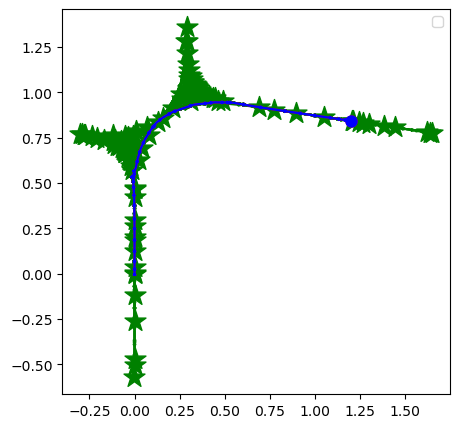

In [17]:
alpha_crit_v3 = 10
path, other_paths = augmented_dijkstra_v3(SC, start, end, ref_path, alpha_crit_v3, 0, True)
print(alpha_crit_v3)
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=True)

In [ ]:
len_path = len(path.nodes)
np.linalg.norm(path.edge_projections - ref_path.edge_projections[:len_path], ord=1, axis=1)

In [ ]:
np.linalg.norm(path.edge_projections - ref_path.edge_projections[-1], ord=1, axis=1)

# Simple Example

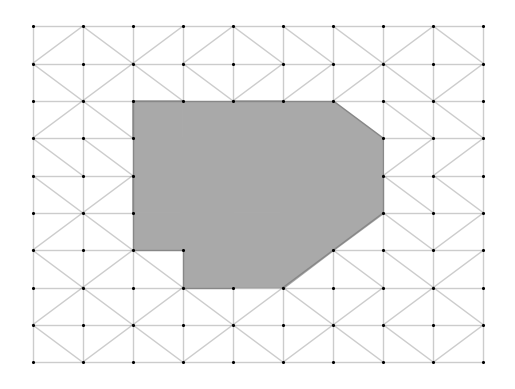

In [8]:
n_side, point_gen_mode = 10, 0

r1, r2 = 0, 0.5
n_holes = 1
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, 1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

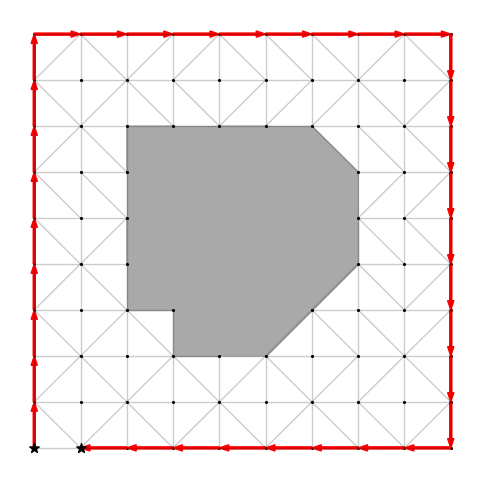

In [9]:
ref_path_coords = [(-1,-1), (-1, 1), (1,1), (1,-1), (-0.8,-1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')

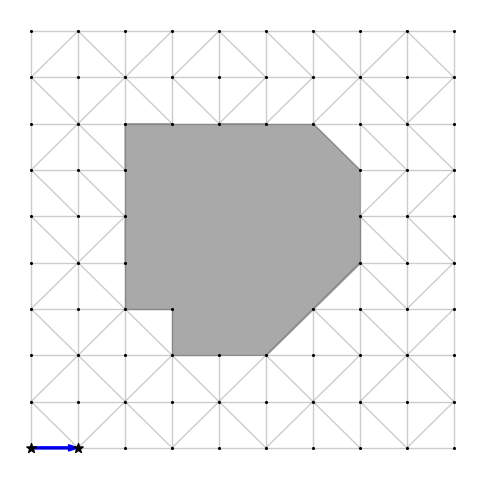

In [10]:
shortest_path_coords = [(-1,-1), (-0.8, -1)]
num_paths, num_nodes = 1, 1

shortest_path_class = Trajectory_Class(SC)
shortest_path_class.generate_paths(shortest_path_coords, num_paths, num_nodes, 1e-1)
shortest_path = shortest_path_class.paths[0]
shortest_path_class.plot_paths('blue', 'shortest')

path: 0-10-20-30-40-50-60-70-80-90-91-92-93-94-95-96-97-98-99-89-79-69-59-49-39-29-19-9-8-7-6-5-4-3-2-1, shortest_path: 0-1
[2.07128545] [-0.01606735]


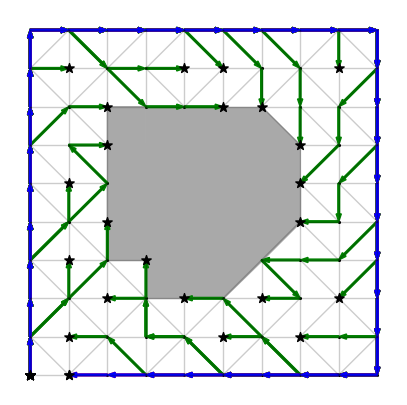

In [11]:
alpha = 235.15 # If alpha is at least 235.15, then ref path is output
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha, 0,  True)
print(f"path: {path}, shortest_path: {shortest_path}")
print(path.edge_projections[-1], shortest_path.edge_projections[-1])
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=True, plot_proj=False)


path: 0-1, shortest_path: 0-1
[-0.01606735] [-0.01606735]


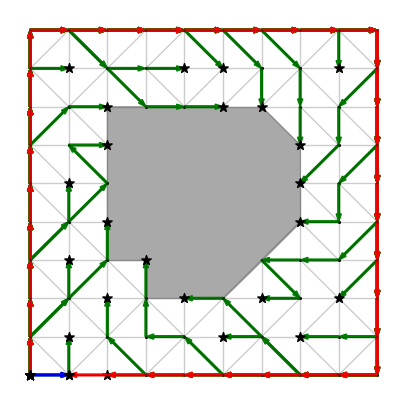

In [12]:
alpha = 100
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha, 0,  True)
print(f"path: {path}, shortest_path: {shortest_path}")
print(path.edge_projections[-1], shortest_path.edge_projections[-1])
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=True, plot_proj=False)

path: 0-10-20-30-40-50-60-70-80-90-91-92-93-94-95-96-97-98-99-89-79-69-59-49-39-29-19-9-8-7-6-5-4-3-2-1, shortest_path: 0-1
[2.07128545] [-0.01606735]


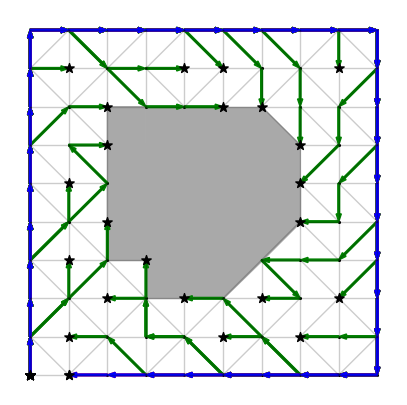

In [30]:
alpha = 235.2
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha, 0,  True)
print(f"path: {path}, shortest_path: {shortest_path}")
print(path.edge_projections[-1], shortest_path.edge_projections[-1])
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=True, plot_proj=False)

In [32]:
proj_diff = np.linalg.norm(path.edge_projections[1] - shortest_path.edge_projections[1], 1)
len_diff = ref_path.get_path_length(SC)[-1] - shortest_path.get_path_length(SC)
len_diff[0]/proj_diff

235.12134181052343

# Simple Example 2

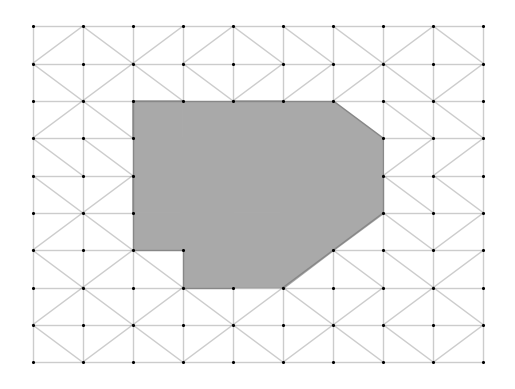

In [11]:
n_side, point_gen_mode = 10, 0

r1, r2 = 0, 0.5
n_holes = 1
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

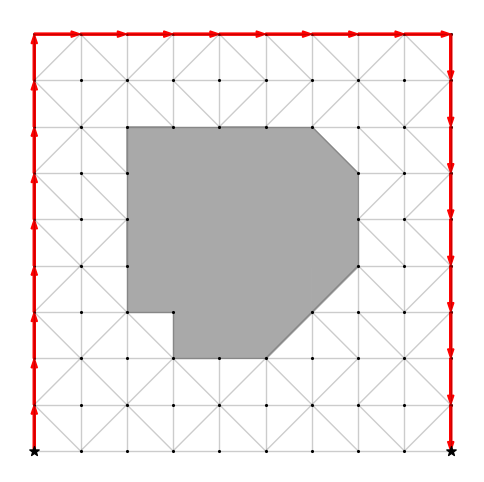

In [12]:
ref_path_coords = [(-1,-1), (-1, 1), (1,1), (1,-1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')
start, end = ref_path.nodes[0], ref_path.nodes[-1]

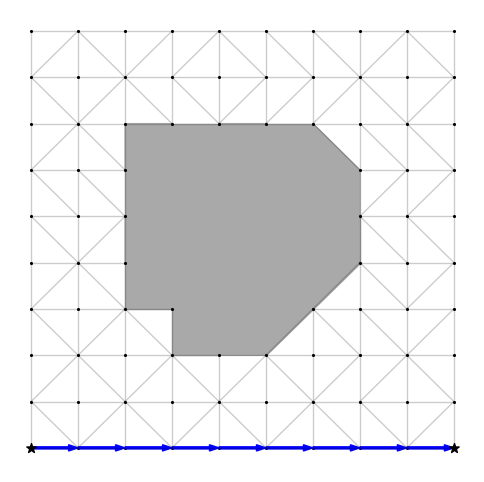

In [13]:
shortest_path_coords = [(-1,-1), (1, -1)]
num_paths, num_nodes = 1, 1

shortest_path_class = Trajectory_Class(SC)
shortest_path_class.generate_paths(shortest_path_coords, num_paths, num_nodes, 1e-1)
shortest_path = shortest_path_class.paths[0]
shortest_path_class.plot_paths('blue', 'shortest')

path: 0-10-20-30-40-50-60-71-72-73-74-84-94-85-86-76-77-67-57-48-49-39-29-28-19-9, shortest_path: 0-1-2-3-4-5-6-7-8-9
[1.63799585] [-0.44935696]


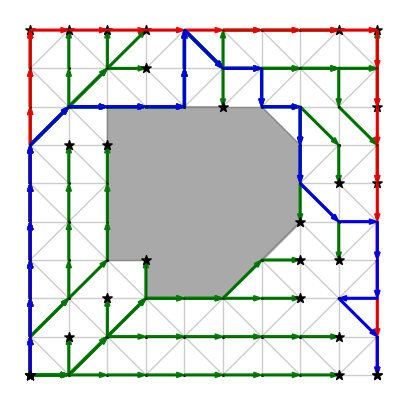

In [15]:
alpha = 4.2
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha, 0,  True)
print(f"path: {path}, shortest_path: {shortest_path}")
print(path.edge_projections[-1], shortest_path.edge_projections[-1])
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=True, plot_proj=False)

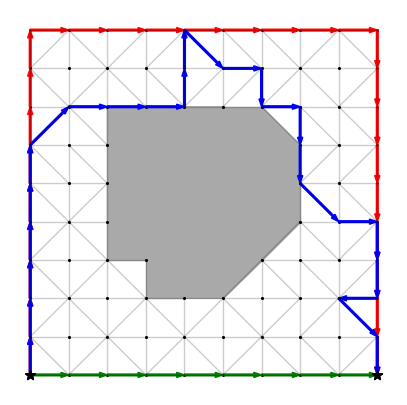

alpha = 0 [5.923745388776086, 2.0]
alpha = 1 [8.499464915850716, 6.800617288742294]
alpha = 2 [11.075184442925345, 11.601234577484588]
alpha = 3 [13.650903969999973, 16.40185186622688]


In [10]:
custom_path_coords = [(-1,-1), (-1,-1+4/3), ((1,-1+4/3)), (1, -1)]
num_paths, num_nodes = 1, 1

custom_path_class = Trajectory_Class(SC)
custom_path_class.generate_paths(custom_path_coords, num_paths, num_nodes, 1e-1)
custom_path = custom_path_class.paths[0]

dijkstra_tree(SC, path, [shortest_path], ref_path_class, plot_others=True, plot_proj=False)


def compute_cost(SC, path1, path2, alpha):
    proj_diffs = np.linalg.norm(path1.edge_projections - path2.edge_projections[:len(path1.nodes)], 1)
    proj_diff_sum = np.sum(proj_diffs)
    path_len = path1.get_path_length(SC)[-1]
    return path_len + alpha * proj_diff_sum

#custom_len, custom_proj_diff = compute_cost(SC, custom_path, ref_path)
#output_len, output_proj_diff = compute_cost(SC, path, ref_path)
#shortest_len, shortest_proj_diff = compute_cost(SC, shortest_path, ref_path)

alphas = [0, 1, 2, 3]

for alpha in alphas:
    output_cost = compute_cost(SC, path, ref_path, alpha)
    shortest_cost = compute_cost(SC, shortest_path, ref_path, alpha)
    print(f"alpha = {alpha}", [output_cost, shortest_cost])


# Counter example
When alpha = 2, the shortest cost path should not be the shortest path, but that is the one that is returned by the algorithm.
Therefore, this algorithm is not optimal for solving the optimization problem

path: 0-1-2-3-4-5-6-7-8-9, shortest_path: 0-1-2-3-4-5-6-7-8-9
[-0.44935696] [-0.44935696]


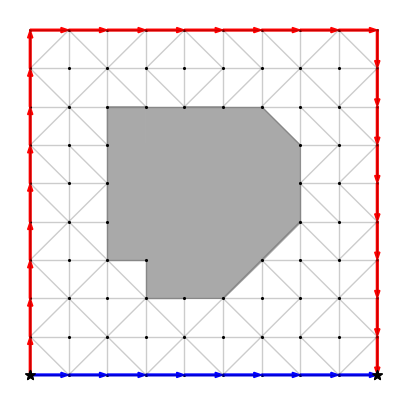

In [16]:
alpha = 2
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha, 0,  True)
print(f"path: {path}, shortest_path: {shortest_path}")
print(path.edge_projections[-1], shortest_path.edge_projections[-1])
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=False, plot_proj=False)